In [1]:
import geopandas as gpd
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score


In [2]:
merged_data = gpd.read_file("data/merged_data_allmonths_selectedbands_cloud20.geojson")


In [5]:
# Assuming your data is loaded into df
# Get unique species
unique_species = merged_data['l3_species'].unique()

# Create a new label DataFrame with rows = images and columns = species, initialized to 0
merged_data['id'] = range(len(merged_data))
labels = pd.DataFrame(0, index=merged_data['id'], columns=unique_species)

# Populate the label DataFrame
for idx, row in merged_data.iterrows():
    species = row['l3_species']
    labels.loc[row['id'], species] = 1

# Reset the index for better readability (optional)
labels.reset_index(inplace=True)
labels.rename(columns={'index': 'id'}, inplace=True)
labels = labels.iloc[:, 1:]

# Show the resulting DataFrame
print(labels)

       european beech  cherry  european ash  linden  sycamore maple  \
0                   1       0             0       0               0   
1                   1       0             0       0               0   
2                   1       0             0       0               0   
3                   1       0             0       0               0   
4                   1       0             0       0               0   
...               ...     ...           ...     ...             ...   
86440               0       0             0       0               0   
86441               0       0             0       0               0   
86442               0       0             0       0               0   
86443               0       0             0       0               0   
86444               0       0             0       0               0   

       english oak  red oak  sessile oak  alder  birch  poplar  douglas fir  \
0                0        0            0      0      0       0      

In [6]:
labels = labels.values

print(labels)

[[1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]]


In [8]:
#labels_np = np.array(labels)
print(labels[0:10, :])
print(type(labels))
print(merged_data.head())

[[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
<class 'numpy.ndarray'>
                                                 B11  \
0  [ [ 0.30860000848770142, 0.30860000848770142, ...   
1  [ [ 0.18799999356269836, 0.19380000233650208, ...   
2  [ [ 0.20035000145435333, 0.20675000548362732, ...   
3  [ [ 0.2955000102519989, 0.27259999513626099, 0...   
4  [ [ 0.26890000700950623, 0.26890000700950623, ...   

                                                  B3  \
0  [ [ 0.14970000088214874, 0.14970000088214874, ...   
1  [ [ 0.12559999525547028, 0.11900000274181366, ...   
2  [ [ 0.12770000100135803, 0.12745000422000885, ...   
3  [

In [10]:
band_data = merged_data.iloc[:, :-5]
print(band_data.head())
#band_data = filtered_data.to_numpy()  # Convert to numpy array of shape (37901, 4)

                                                 B11  \
0  [ [ 0.30860000848770142, 0.30860000848770142, ...   
1  [ [ 0.18799999356269836, 0.19380000233650208, ...   
2  [ [ 0.20035000145435333, 0.20675000548362732, ...   
3  [ [ 0.2955000102519989, 0.27259999513626099, 0...   
4  [ [ 0.26890000700950623, 0.26890000700950623, ...   

                                                  B3  \
0  [ [ 0.14970000088214874, 0.14970000088214874, ...   
1  [ [ 0.12559999525547028, 0.11900000274181366, ...   
2  [ [ 0.12770000100135803, 0.12745000422000885, ...   
3  [ [ 0.14280000329017639, 0.13089999556541443, ...   
4  [ [ 0.14720000326633453, 0.14720000326633453, ...   

                                                  B4  \
0  [ [ 0.15119999647140503, 0.15119999647140503, ...   
1  [ [ 0.1185000017285347, 0.1136000007390976, 0....   
2  [ [ 0.12514999508857727, 0.12649999558925629, ...   
3  [ [ 0.15320000052452087, 0.1387999951839447, 0...   
4  [ [ 0.15099999308586121, 0.1509999930858612

In [11]:
# Convert each element in the 'B2_3', 'B4_3', 'B8_3', 'NDVI_3' columns into actual lists
import ast

band_data['B3'] = band_data['B3'].apply(ast.literal_eval)
band_data['B4'] = band_data['B4'].apply(ast.literal_eval)
band_data['B6'] = band_data['B6'].apply(ast.literal_eval)
band_data['B8'] = band_data['B8'].apply(ast.literal_eval)
band_data['B11'] = band_data['B11'].apply(ast.literal_eval)
band_data['NDVI'] = band_data['NDVI'].apply(ast.literal_eval)

In [12]:
# Initialize the 4D array to store the reshaped data
rows = len(band_data)
X = np.zeros((rows, 11, 11, 6), dtype=np.float32)

# Loop through the rows and fill the 4D array with the band data
for i in range(rows):
    # Convert the list of lists into a NumPy array for each band
    band_b3 = np.array(band_data['B3'][i], dtype=np.float32)  # Shape (11, 11)
    band_b4 = np.array(band_data['B4'][i], dtype=np.float32)  # Shape (11, 11)
    band_b6 = np.array(band_data['B6'][i], dtype=np.float32) 
    band_b8 = np.array(band_data['B8'][i], dtype=np.float32)
    band_b11 = np.array(band_data['B11'][i], dtype=np.float32) # Shape (11, 11)
    band_ndvi = np.array(band_data['NDVI'][i], dtype=np.float32)  # Shape (11, 11)

    # Stack the bands together into a 3D array (11, 11, 4)
    # This will create a 3D array where each band is along the 3rd axis (depth)
    X[i, :, :, 0] = band_b3
    X[i, :, :, 1] = band_b4
    X[i, :, :, 2] = band_b6
    X[i, :, :, 4] = band_b11
    X[i, :, :, 3] = band_b8
    X[i, :, :, 5] = band_ndvi

In [13]:
print(X.shape)

(86445, 11, 11, 6)


In [19]:
np.save('data/labels_nparray.bpy', labels)

(array([ 9297.,   455.,  4518.,   367.,  4190.,  7085.,  3435.,  4484.,
         5289.,  5785.,  1029.,  5136.,  2090.,  2494.,  4078.,  1092.,
        14178.,  1259., 10184.]),
 array([ 0.        ,  0.94736842,  1.89473684,  2.84210526,  3.78947368,
         4.73684211,  5.68421053,  6.63157895,  7.57894737,  8.52631579,
         9.47368421, 10.42105263, 11.36842105, 12.31578947, 13.26315789,
        14.21052632, 15.15789474, 16.10526316, 17.05263158, 18.        ]),
 <BarContainer object of 19 artists>)

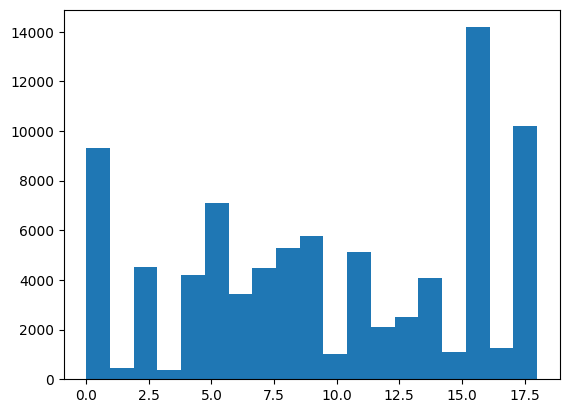

In [17]:
plt.hist(np.argmax(labels, axis=1), bins = 19)

In [28]:
def true_color(X):
    """ Define True Color Sentinel image    
    The function returns the MinMax scaled RGB bands.
    Matplot convention RGB [0, 255]    
    """    
    blue = X[:,:,0] / (X[:,:,0].max()/255.0)
    green = X[:,:,2] / (X[:,:,2].max()/255.0)
    red = X[:,:,1] / (X[:,:,1].max()/255.0)
    
    tc = np.dstack((red, green, blue))     
    
    return tc.astype('uint8')


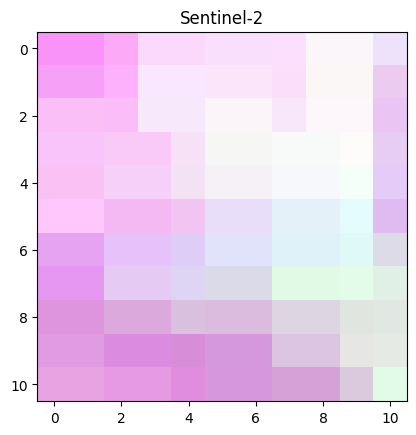

In [29]:
# show one patch
plt.imshow(true_color(X[0,:,:,1:3]))
plt.title('Sentinel-2')

plt.show()

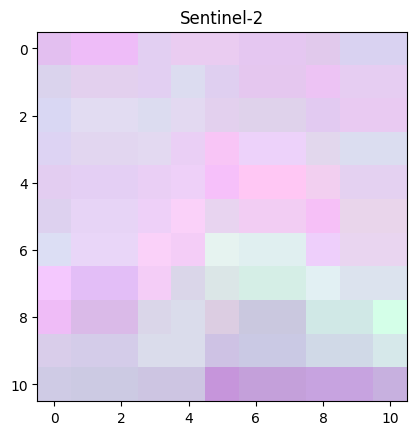

In [20]:
plt.imshow(true_color(X[37900,:,:,0:3]))
plt.title('Sentinel-2')

plt.show()

In [21]:
number_samples = X.shape[0]
X_res = np.reshape(X, (number_samples, 11*11*6))
y_res = np.argmax(labels, axis=1)

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=24, shuffle=True)

In [22]:
rf_classifier = RandomForestClassifier(random_state=24)

rf_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=24)

18


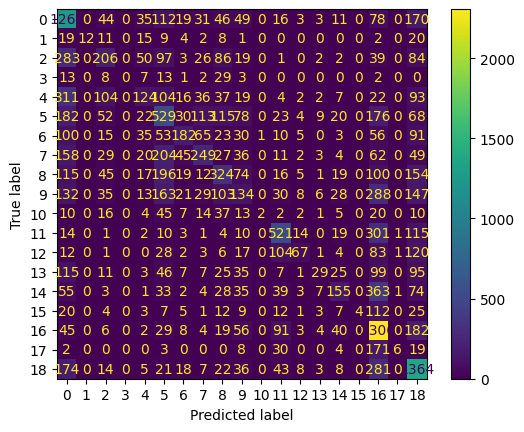

Accuracy Random Forest Classifier:  0.4323558331887327


In [23]:
y_pred_rf = rf_classifier.predict(X_test)
print(np.max(y_pred_rf))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf)
plt.show()

acc_rf = accuracy_score(y_test, y_pred_rf)
print("Accuracy Random Forest Classifier: ", acc_rf)

In [31]:
unique_leaf = merged_data['l1_leaf_types'].unique()

# Create a new label DataFrame with rows = images and columns = species, initialized to 0

leaf_labels = pd.DataFrame(0, index=merged_data['id'], columns=unique_leaf)

# Populate the label DataFrame
for idx, row in merged_data.iterrows():
    leaf = row['l1_leaf_types']
    leaf_labels.loc[row['id'], leaf] = 1

# Reset the index for better readability (optional)
leaf_labels.reset_index(inplace=True)
leaf_labels.rename(columns={'index': 'id'}, inplace=True)
leaf_labels = leaf_labels.iloc[:, 1:]

# Show the resulting DataFrame
print(leaf_labels)

leaf_labels = leaf_labels.values

       broadleaf  needleleaf
0              1           0
1              1           0
2              1           0
3              1           0
4              1           0
...          ...         ...
86440          0           1
86441          0           1
86442          0           1
86443          0           1
86444          0           1

[86445 rows x 2 columns]


In [32]:
np.save('data/leaf_labels_nparray.bpy', leaf_labels)